<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">

# snnTorch - Gradient-based Learning in Spiking Neural Networks
## Tutorial 2
### By Jason K. Eshraghian

<a href="https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Introduction
In this tutorial, you will learn how to use snnTorch to:
* create a 2-layer fully-connected spiking network;
* implement the backpropagation through time (BPTT) algorithm;
* to classify both the static and spiking MNIST datasets.

If running in Google Colab:
* You may connect to GPU by checking `Runtime` > `Change runtime type` > `Hardware accelerator: GPU`
* Next, install the latest PyPi distribution of snnTorch by clicking into the following cell and pressing `Shift+Enter`.

In [5]:
!pip install snntorch

## 1. Setting up the Static MNIST Dataset
### 1.1. Import packages and setup environment

In [6]:
import snntorch as snn
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import itertools
import matplotlib.pyplot as plt

### 1.2 Define network and SNN parameters
We will use a 784-1000-10 FCN architecture for a sequence of 25 time steps.

* `alpha` is the decay rate of the synaptic current of a neuron
* `beta` is the decay rate of the membrane potential of a neuron

In [9]:
# Network Architecture
num_inputs = 32*32
num_hidden = 1000
num_outputs = 10

# Training Parameters
batch_size=128
data_path='/data/mnist'

# Temporal Dynamics
num_steps = 25
time_step = 1e-3
tau_mem = 3e-3
tau_syn = 2.2e-3
alpha = float(np.exp(-time_step/tau_syn))
beta = float(np.exp(-time_step/tau_mem))

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [17]:
alpha = 0.8
beta = 0.9

### 1.3 Download MNIST Dataset
To see how to construct a validation set, refer to Tutorial 1.

In [7]:
# Define a transform
transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)


Extracting /data/mnist/cifar-10-python.tar.gz to /data/mnist
Files already downloaded and verified


### 1.4 Create DataLoaders

In [8]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

## 2. Define Network
snnTorch treats neurons as activations with recurrent connections. This allows for smooth integration with PyTorch.
There are a few useful neuron models and surrogate gradient functions which approximate the gradient of spikes.

Our network will use one type of neuron model and one surrogate gradient:
1. `snntorch.Stein` is a basic leaky integrate and fire (LIF) neuron. Specifically, it assumes instantaneous rise times for synaptic current and membrane potential.
2. `snntorch.FastSigmoidSurrogate` defines separate forward and backward functions. The forward function is a Heaviside step function for spike generation. The backward function is the derivative of a fast sigmoid function, to ensure continuous differentiability.
The `FastSigmoidSurrogate` function has been adapted from:

>Neftci, E. O., Mostafa, H., and Zenke, F. (2019) Surrogate Gradient Learning in Spiking Neural Networks. https://arxiv.org/abs/1901/09948

In [10]:
# from snntorch import surrogate
#
# spike_grad = surrogate.FastSigmoid.apply
# snn.slope = 50

The surrogate is passed to `spike_grad` and overrides the default gradient of the Heaviside step function.
If we did not override the default gradient, (zero everywhere, except for $x=1$ where it is technically infinite but clipped to 1 here), then learning would not take place for as long as the neuron was not emitting post-synaptic spikes.

`snn.slope` defines the slope of the backward surrogate.

TO-DO: Include visualisation.

Now we can define our spiking neural network (SNN).
Creating an instance of the `Stein` neuron requires two arguments and two optional arguments:
1. $I_{syn}$ decay rate, $\alpha$,
2. $V_{mem}$ decay rate, $\beta$,
3. the surrogate spiking function, `spike_grad` (*default*: the gradient of the Heaviside function), and
4. the threshold for spiking, (*default*: 1.0).

snnTorch treats the LIF neuron as a recurrent activation. Therefore, it requires initialization of its internal states.
For each layer, we initialize the synaptic current `syn1` and `syn2`, the membrane potential `mem1` and `mem2`, and the post-synaptic spikes `spk1` and `spk2` to zero.
A class method `init_stein` will take care of this.

For rate coding, the final layer of spikes and membrane potential are used to determine accuracy and loss, respectively.
So their historical values are recorded in `spk2_rec` and `mem2_rec`.

Keep in mind, the dataset we are using is just static MNIST. I.e., it is *not* time-varying.
Therefore, we pass the same MNIST sample to the input at each time step.
This is handled in the line `cur1 = self.fc1(x)`, where `x` is the same input over the whole for-loop.

In [18]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

    # initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Stein(alpha=alpha, beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Stein(alpha=alpha, beta=beta)

    def forward(self, x):
        spk1, syn1, mem1 = self.lif1.init_stein(batch_size, num_hidden)
        spk2, syn2, mem2 = self.lif2.init_stein(batch_size, num_outputs)

        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, syn1, mem1 = self.lif1(cur1, syn1, mem1)
            cur2 = self.fc2(spk1)
            spk2, syn2, mem2 = self.lif2(cur2, syn2, mem2)

            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

net = Net().to(device)

## 3. Training
Time for training! Let's first define a couple of functions to print out test/train accuracy.

In [19]:
def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train Set Accuracy: {acc}")
    else:
        print(f"Test Set Accuracy: {acc}")

def train_printer():
    print(f"Epoch {epoch}, Minibatch {minibatch_counter}")
    print(f"Train Set Loss: {loss_hist[counter]}")
    print(f"Test Set Loss: {test_loss_hist[counter]}")
    print_batch_accuracy(data_it, targets_it, train=True)
    print_batch_accuracy(testdata_it, testtargets_it, train=False)
    print("\n")

### 3.1 Optimizer & Loss
* *Output Activation*: We'll apply the softmax function to the membrane potentials of the output layer, rather than the spikes.
* *Loss*: This will then be used to calculate the negative log-likelihood loss.
By encouraging the membrane of the correct neuron class to reach the threshold, we expect that neuron will fire more frequently.
The loss could be applied to the spike count as well, but the membrane is  continuous whereas spike count is discrete.
* *Optimizer*: The Adam optimizer is used for weight updates.
* *Accuracy*: Accuracy is measured by counting the spikes of the output neurons. The neuron that fires the most frequently will be our predicted class.

In [20]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-4, betas=(0.9, 0.999))
log_softmax_fn = nn.LogSoftmax(dim=-1)
loss_fn = nn.NLLLoss()

### 3.2 Training Loop
Now just sit back, relax, and wait for convergence.

In [21]:
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(3):
    minibatch_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data_it, targets_it in train_batch:
        data_it = data_it.to(device)
        targets_it = targets_it.to(device)

        output, mem_rec = net(data_it.view(batch_size, -1))
        log_p_y = log_softmax_fn(mem_rec)
        loss_val = torch.zeros((1), dtype=dtype, device=device)

        # Sum loss over time steps: BPTT
        for step in range(num_steps):
          loss_val += loss_fn(log_p_y[step], targets_it)

        # Gradient calculation
        optimizer.zero_grad()
        loss_val.backward(retain_graph=True)

        # Weight Update
        nn.utils.clip_grad_norm_(net.parameters(), 1) # gradient clipping
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        test_data = itertools.cycle(test_loader)
        testdata_it, testtargets_it = next(test_data)
        testdata_it = testdata_it.to(device)
        testtargets_it = testtargets_it.to(device)

        # Test set forward pass
        test_output, test_mem_rec = net(testdata_it.view(batch_size, -1))

        # Test set loss
        log_p_ytest = log_softmax_fn(test_mem_rec)
        log_p_ytest = log_p_ytest.sum(dim=0)
        loss_val_test = loss_fn(log_p_ytest, testtargets_it)
        test_loss_hist.append(loss_val_test.item())

        # Print test/train loss/accuracy
        if counter % 50 == 0:
            train_printer()
        minibatch_counter += 1
        counter += 1

loss_hist_true_grad = loss_hist
test_loss_hist_true_grad = test_loss_hist

Epoch 2, Minibatch 70
Train Set Loss: 53.006282806396484
Test Set Loss: 55.81739807128906
Train Set Accuracy: 0.2265625
Test Set Accuracy: 0.21875


Epoch 2, Minibatch 120
Train Set Loss: 50.85497283935547
Test Set Loss: 50.894222259521484
Train Set Accuracy: 0.265625
Test Set Accuracy: 0.3125


Epoch 2, Minibatch 170
Train Set Loss: 49.45563507080078
Test Set Loss: 50.29939651489258
Train Set Accuracy: 0.3671875
Test Set Accuracy: 0.2578125


Epoch 2, Minibatch 220
Train Set Loss: 52.987083435058594
Test Set Loss: 51.679054260253906
Train Set Accuracy: 0.2109375
Test Set Accuracy: 0.234375


Epoch 2, Minibatch 270
Train Set Loss: 49.68134307861328
Test Set Loss: 52.56451416015625
Train Set Accuracy: 0.3359375
Test Set Accuracy: 0.234375


Epoch 2, Minibatch 320
Train Set Loss: 54.24823760986328
Test Set Loss: 51.5257682800293
Train Set Accuracy: 0.25
Test Set Accuracy: 0.25


Epoch 2, Minibatch 370
Train Set Loss: 50.897029876708984
Test Set Loss: 49.811622619628906
Train Set Accuracy

KeyboardInterrupt: ignored

## 4. Results
### 4.1 Plot Training/Test Loss

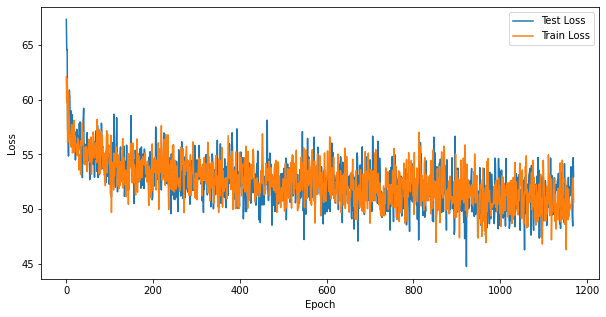

In [14]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.legend(["Test Loss", "Train Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### 4.2 Test Set Accuracy
This function just iterates over all minibatches to obtain a measure of accuracy over the full 10,000 samples in the test set.

In [15]:
total = 0
correct = 0
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data in test_loader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)

    # If current batch matches batch_size, just do the usual thing
    if images.size()[0] == batch_size:
      outputs, _ = net(images.view(batch_size, -1))

    # If current batch does not match batch_size (e.g., is the final minibatch),
    # modify batch_size in a temp variable and restore it at the end of the else block
    else:
      temp_bs = batch_size
      batch_size = images.size()[0]
      outputs, _ = net(images.view(images.size()[0], -1))
      batch_size = temp_bs

    _, predicted = outputs.sum(dim=0).max(1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total}%")

Total correctly classified test set images: 2923/10000
Test Set Accuracy: 29.23%


Voila! That's it for static MNIST.

## 5. Spiking MNIST
Part of the appeal of SNNs is their ability to handle time-varying spiking data. So let's use rate-coding to convert MNIST into spiking MNIST using the `spikegen` module in the previous tutorial, and train our network with that instead.

In [33]:
from snntorch import spikegen

# MNIST to spiking-MNIST
spike_data, spike_targets = spikegen.rate(data_it, targets_it, num_steps=num_steps)

### 5.1 Visualiser
Just so you're damn sure it's a spiking input.

In [28]:
!pip install celluloid # matplotlib animations made easy

In [39]:
data_it.size()

torch.Size([128, 1, 32, 32])

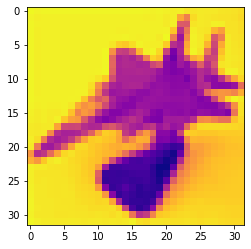

In [46]:
fig, ax = plt.subplots()
ax.imshow(data_it[0, 0].cpu(), cmap='plasma')

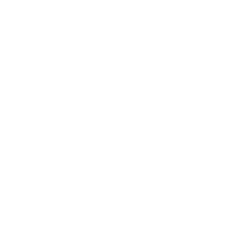

In [38]:
from celluloid import Camera
from IPython.display import HTML

# Animator
spike_data_sample = spike_data.unsqueeze(2)[:, 0, 0].cpu()

fig, ax = plt.subplots()
camera = Camera(fig)
plt.axis('off')

for step in range(num_steps):
    im = ax.imshow(spike_data_sample[step, :, :].squeeze(0), cmap='plasma')
    camera.snap()

# interval=40 specifies 40ms delay between frames
a = camera.animate(interval=40)
HTML(a.to_html5_video())

In [ ]:
print(spike_targets[0])

## 6. Define Network
The network is the same as before. The one difference is that the for-loop iterates through the first dimension of the input:
`cur1 = self.fc1(x[step])`

In [ ]:
spike_grad = snn.FastSigmoidSurrogate.apply
snn.slope = 50 # The lower the slope, the smoother the gradient

# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Stein(alpha=alpha, beta=beta, spike_grad=spike_grad)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Stein(alpha=alpha, beta=beta, spike_grad=spike_grad)

    def forward(self, x):
        # Initialize hidden states + output spike at t=0
        spk1, syn1, mem1 = self.lif1.init_stein(batch_size, num_hidden)
        spk2, syn2, mem2 = self.lif2.init_stein(batch_size, num_outputs)

        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x[step])
            spk1, syn1, mem1 = self.lif1(cur1, syn1, mem1)
            cur2 = self.fc2(spk1)
            spk2, syn2, mem2 = self.lif2(cur2, syn2, mem2)

            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

net = Net().to(device)

## 7. Training
We make a slight modification to our print-out functions to handle the new first dimension of the input:

In [ ]:
def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(num_steps, batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train Set Accuracy: {acc}")
    else:
        print(f"Test Set Accuracy: {acc}")

def train_printer():
    print(f"Epoch {epoch}, Minibatch {minibatch_counter}")
    print(f"Train Set Loss: {loss_hist[counter]}")
    print(f"Test Set Loss: {test_loss_hist[counter]}")
    print_batch_accuracy(spike_data, spike_targets, train=True)
    print_batch_accuracy(test_spike_data, test_spike_targets, train=False)
    print("\n")


### 7.1 Optimizer & Loss
We'll keep our optimizer and loss the exact same as the static MNIST case.

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-4, betas=(0.9, 0.999))
log_softmax_fn = nn.LogSoftmax(dim=-1)
loss_fn = nn.NLLLoss()

### 7.2 Training Loop
The training loop is identical to the static MNIST case, but we pass each minibatch through `spikegen.rate` before running it through the feedforward network.

In [ ]:
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(3):
    minibatch_counter = 0
    data = iter(train_loader)

    # Minibatch training loop
    for data_it, targets_it in data:
        data_it = data_it.to(device)
        targets_it = targets_it.to(device)

        # Spike generator
        spike_data, spike_targets = spikegen.rate(data_it, targets_it, num_outputs=num_outputs, num_steps=num_steps,
                                                  gain=1, offset=0, convert_targets=False, temporal_targets=False)

        # Forward pass
        output, mem_rec = net(spike_data.view(num_steps, batch_size, -1))
        log_p_y = log_softmax_fn(mem_rec)
        loss_val = torch.zeros((1), dtype=dtype, device=device)

        # Sum loss over time steps to perform BPTT
        for step in range(num_steps):
          loss_val += loss_fn(log_p_y[step], targets_it)

        # Gradient Calculation
        optimizer.zero_grad()
        loss_val.backward(retain_graph=True)
        nn.utils.clip_grad_norm_(net.parameters(), 1)

        # Weight Update
        optimizer.step()

        # Store Loss history
        loss_hist.append(loss_val.item())

        # Test set
        test_data = itertools.cycle(test_loader)
        testdata_it, testtargets_it = next(test_data)
        testdata_it = testdata_it.to(device)
        testtargets_it = testtargets_it.to(device)

        # Test set spike conversion
        test_spike_data, test_spike_targets = spikegen.rate(testdata_it, testtargets_it, num_outputs=num_outputs,
                                                            num_steps=num_steps, gain=1, offset=0, convert_targets=False, temporal_targets=False)

        # Test set forward pass
        test_output, test_mem_rec = net(test_spike_data.view(num_steps, batch_size, -1))

        # Test set loss
        log_p_ytest = log_softmax_fn(test_mem_rec)
        log_p_ytest = log_p_ytest.sum(dim=0)
        loss_val_test = loss_fn(log_p_ytest, test_spike_targets)
        test_loss_hist.append(loss_val_test.item())

        # Print test/train loss/accuracy
        if counter % 50 == 0:
            train_printer()
        minibatch_counter += 1
        counter += 1

loss_hist_true_grad = loss_hist
test_loss_hist_true_grad = test_loss_hist

## 8. Spiking MNIST Results
### 8.1 Plot Training/Test Loss

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.legend(["Test Loss", "Train Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### 8.2 Test Set Accuracy

In [ ]:
total = 0
correct = 0
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data in test_loader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)

    # If current batch matches batch_size, just do the usual thing
    if images.size()[0] == batch_size:
      spike_test, spike_targets = spikegen.rate(images, labels, num_outputs=num_outputs, num_steps=num_steps,
                                                            gain=1, offset=0, convert_targets=False, temporal_targets=False)

      outputs, _ = net(spike_test.view(num_steps, batch_size, -1))

    # If current batch does not match batch_size (e.g., is the final minibatch),
    # modify batch_size in a temp variable and restore it at the end of the else block
    else:
      temp_bs = batch_size
      batch_size = images.size()[0]
      spike_test, spike_targets = spikegen.rate(images, labels, num_outputs=num_outputs, num_steps=num_steps,
                                                gain=1, offset=0, convert_targets=False, temporal_targets=False)

      outputs, _ = net(spike_test.view(num_steps, images.size()[0], -1))
      batch_size = temp_bs

    _, predicted = outputs.sum(dim=0).max(1)
    total += spike_targets.size(0)
    correct += (predicted == spike_targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total}%")

That's all for now!
Next time, we'll introduce how to use spiking convolutional layers to improve accuracy.